# Compute SNR of signal with and without gaps

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime
from astropy import units as u

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import ESAOrbits, EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral
from few.utils.utility import get_p_at_t
from few.utils.fdutils import *

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from eryn.backends import HDFBackend

from fastlisaresponse import pyResponseTDI, ResponseWrapper

try:
    import cupy as cp
except Exception:
    cp = None

In [2]:
# gpu
use_gpu = False

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

In [4]:
# Observation parameters
Tobs = 1  # [years]
dt = 50.0  # [s]
eps = 1e-4  # mode content

emri_waveform_kwargs = dict(T=Tobs, dt=dt, eps=eps)

In [5]:
# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
p0 = 8.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3



emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

In [6]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"

response_kwargs = dict(
        Tobs=Tobs,
        dt=dt,
        t0 = 100000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=EqualArmlengthOrbits(),
    )

In [7]:
# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=True,
                                **response_kwargs)




def fastlisaresponse(*params, emri_waveform_kwargs=None):
    return lisa_response(*params, **(emri_waveform_kwargs or {}))

In [8]:
# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 11.76 s


In [9]:
# Compute f_min
r_apo = p0 * M * MTSUN_SI / (1 - e0)  # meters
r_per = p0 * M * MTSUN_SI / (1 + e0)  # meters
r0 = (r_apo+r_per)/2

f_orb_0 = np.sqrt(M * MTSUN_SI / r0**3) / (2 * np.pi)  # rad/s

f_min = 2 * f_orb_0

In [10]:
# Generate TD noise
def generate_time_domain_noise_lisa(pos_psd, dt, N_obs):

    sigma = 0.5 * (pos_psd / (1.0 / (N_obs * dt))) ** 0.5

    noise_real = np.random.normal(0.0, sigma) + 1j * np.random.normal(0.0, sigma)

    noise_time_domain = np.fft.irfft(noise_real, n=N_obs) / dt

    return noise_time_domain

In [11]:
# Add TD noise
def add_TDI_noise(chans, dt, f_min):
    N_obs = len(chans[0])
    freq = np.fft.fftshift(np.fft.fftfreq(N_obs , dt))
    positive_frequency_mask = (freq>f_min)

    # generate psd
    pos_psd_A = get_sensitivity(freq[positive_frequency_mask], sens_fn='A1TDISens', return_type="PSD")
    pos_psd_E = get_sensitivity(freq[positive_frequency_mask], sens_fn='E1TDISens', return_type="PSD")

    # generate two realizations for the noise (A and E)
    noise_td_A = np.asarray(generate_time_domain_noise_lisa(pos_psd_A, dt, N_obs))
    noise_td_E = np.asarray(generate_time_domain_noise_lisa(pos_psd_E, dt, N_obs))

    # add TD noise to TD signal
    chans_noise = chans.copy()
    chans_noise[0] = chans[0] + noise_td_A
    chans_noise[1] = chans[1] + noise_td_E

    return chans_noise

In [12]:
chans_noise = add_TDI_noise(chans, dt, f_min)

### Signal (template) with **NO** gaps

In [13]:
# Cut the data for f>f_min
complete_data = DataResidualArray(chans_noise, dt=dt)

freq_threshold = f_min
freqs = complete_data.f_arr
mask = freqs > freq_threshold

data_filtered = complete_data[:,mask]
freq_filtered = freqs[mask]

data = DataResidualArray(data_filtered, f_arr=freq_filtered)

sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

In [14]:
# Define template (no noise, no gaps)
def signal_gen(*emri_waveform_args):
    complete_data = DataResidualArray(fastlisaresponse(*emri_waveform_args, emri_waveform_kwargs=emri_waveform_kwargs), dt=dt)

    freqs = complete_data.f_arr
    mask = freqs > freq_threshold

    return DataResidualArray(complete_data[:, mask], f_arr=freqs[mask])

In [15]:
analysis = AnalysisContainer(data, sens_mat, signal_gen=signal_gen)

Compute template (only signal, no noise) SNR:
- Optimal SNR

$$ \rho_{opt} = \sqrt{\langle \tilde{h}(f) | \tilde{h}(f)\rangle} $$
  
- Detected SNR

$$ \rho_{det} = \frac{ \langle \tilde{d}(f) | \tilde{h}(f)\rangle}{  \sqrt{\langle \tilde{h}(f) | \tilde{h}(f)\rangle} }$$


In [16]:
optimal_snr_NOgaps, detected_snr_NOgaps = analysis.template_snr(signal_gen(*emri_waveform_args))

print('Optimal snr for no gaps template:', optimal_snr_NOgaps)
print('Detected snr for no gaps template with not-gapped data:', detected_snr_NOgaps)

Optimal snr for no gaps template: 90.24182391760165
Detected snr for no gaps template with not-gapped data: 89.80382097776766


### Signal (template) with gaps

In [17]:
# conversions
day  = u.day        # Quantity unit (1 day)
hour = u.hour       # Quantity unit (1 hour)
year = 365.25 * u.day   # Julian year as a Quantity

years_to_s = (year).to(u.s).value
days_to_s = (day).to(u.s)
hours_to_s = (hour).to(u.s)

In [18]:
# function to generate periodic gaps (like the planned ones)
def gen_periodic_gaps(chans, dt, w_total, gap_s, period_s, seed=None):

    rng = np.random.default_rng(seed)

    N_tot = len(chans[0])

    # conversion of gaps and their period to samples
    gap_samples = int(np.round(gap_s / dt))
    period_samples = int(np.round(period_s / dt))

    # random start within one period
    start_idx = int(rng.integers(1, period_samples))
    
    # create mask
    w_local = np.ones(N_tot, dtype=int)
    starts = np.arange(start_idx, N_tot, period_samples)
    for s in starts:
        e = min(s + gap_samples, N_tot)  # within the end of the signal
        w_local[s:e] = 0

    # apply mask
    chans_gap = chans.copy() * w_local
    w_final = w_total.copy() * w_local

    return chans_gap, w_final, starts



In [19]:
# function to generate planned gaps (the ones presented in Burke+2025)
def gen_planned_gaps(chans, dt, seed=None):
    N_tot = len(chans[0])
    w_total = np.ones(N_tot, dtype=int)
    
    # Antenna re-pointing    
    gap_ant = 3 * hours_to_s
    period_ant = 14 * days_to_s

    chans_gap_ant, w_final_ant, starts_ant = gen_periodic_gaps(chans, dt, w_total, gap_ant, period_ant, seed=seed)

    
    # Tilt-to-length coupling constant estimation
    gap_ttl = 2 * days_to_s
    period_ttl = 0.25 * years_to_s # 4 times a year

    chans_gap_ttl, w_final_ttl, starts_ttl = gen_periodic_gaps(chans_gap_ant, dt, w_final_ant, gap_ttl, period_ttl, seed=seed)
    

    # point-ahead angle mechanism (PAAM) adjustments
    gap_PAAM = 100
    period_PAAM = (1/3) * days_to_s

    chans_gap_PAAM, w_final_PAAM, starts_PAAM = gen_periodic_gaps(chans_gap_ttl, dt, w_final_ttl, gap_PAAM, period_PAAM, seed=seed)


    return chans_gap_PAAM, w_final_PAAM, starts_ant, starts_ttl, starts_PAAM
    

In [20]:
# Apply gaps
chans_gap, _, _, _, _ = gen_planned_gaps(chans_noise, dt, seed=13)

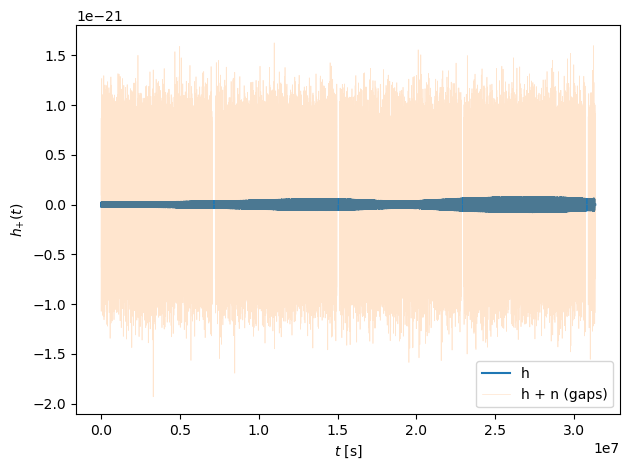

In [21]:
# Visualise the signal

time_array = np.arange(0,len(chans_gap[0]))*dt

plt.plot(time_array, chans[0],label='h')
plt.plot(time_array, chans_gap[0],label='h + n (gaps)', alpha=0.2, linewidth=0.5)
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 1.3*10e3
plt.legend()
plt.tight_layout()

plt.show()

In [22]:
# Cut the data for f>f_min
complete_data = DataResidualArray(chans_gap, dt=dt)

freq_threshold = f_min
freqs = complete_data.f_arr
mask = freqs > freq_threshold

data_filtered = complete_data[:,mask]
freq_filtered = freqs[mask]

data = DataResidualArray(data_filtered, f_arr=freq_filtered)

sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

In [23]:
# Define template WITH GAPS (no noise)
def signal_gen_gaps(*emri_waveform_args):
    chans = fastlisaresponse(*emri_waveform_args, emri_waveform_kwargs=emri_waveform_kwargs)

    chans_gap, _, _, _, _ = gen_planned_gaps(chans, dt, seed=13)

    complete_data = DataResidualArray(chans_gap, dt=dt)

    freqs = complete_data.f_arr
    mask = freqs > freq_threshold

    chans_gap, w_final, starts_ant, starts_ttl, starts_PAAM = gen_planned_gaps(chans_noise, dt, seed=13)

    return DataResidualArray(complete_data[:, mask], f_arr=freqs[mask])

In [24]:
analysis = AnalysisContainer(data, sens_mat, signal_gen=signal_gen_gaps)

In [25]:
optimal_snr_gaps, detected_snr_gaps = analysis.template_snr(signal_gen_gaps(*emri_waveform_args))

print('Optimal snr for template with no gaps:', optimal_snr_NOgaps)
print('Optimal snr for template with planned gaps:', optimal_snr_gaps)

Optimal snr for template with no gaps: 90.24182391760165
Optimal snr for template with planned gaps: 88.40012548572612


### Now I want to check the detected SNR for no gap template in gapped data

In [26]:
analysis = AnalysisContainer(data, sens_mat, signal_gen=signal_gen)

optimal_snr_NOgapsT_gapD, detected_snr_NOgapsT_gapD = analysis.template_snr(signal_gen(*emri_waveform_args))

print('Detected snr for template with NO gaps over not-gapped data:', detected_snr_NOgaps)
print('Detected snr for template with NO gaps over gapped data:', detected_snr_NOgapsT_gapD)

Detected snr for template with NO gaps over not-gapped data: 89.80382097776766
Detected snr for template with NO gaps over gapped data: 86.04413909332109


## Finally, compute the optimal SNR for gapped signal with the best-fit values of the no-gaps template

In [27]:
# best-fit values of the no-gaps template
M = 999976  # central object mass
mu = 9.99988  # secondary object mass
a = 0.499979  # spin (ignored in Schwarzschild waveform)
p0 = 8.20011  # initial semi-latus rectum
e0 = 0.500004  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.02623  # distance
qK = 0.86759  # polar spin angle (theta)
phiK = 1.04876  # azimuthal spin/viewing angle
qS = 0.860036  # polar sky angle
phiS = 1.04939  # azimuthal sky angle
Phi_phi0 = 1.0473
Phi_theta0 = 0.519062
Phi_r0 = 1.03499

In [28]:
emri_waveform_args_bestfit = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

In [29]:
# I use whichever data since it doesn't impact the computation of the optimal snr (only template params)
analysis = AnalysisContainer(data, sens_mat, signal_gen=signal_gen_gaps)

In [30]:
optimal_snr_gaps_bestfit, detected_snr_gaps_bestfit = analysis.template_snr(signal_gen_gaps(*emri_waveform_args_bestfit))

print('Optimal snr for template with no gaps:', optimal_snr_NOgaps)
print('Optimal snr for template with planned gaps:', optimal_snr_gaps)
print('Optimal snr for template with gaps but best fit patamers (from PE with no gaps template):', optimal_snr_gaps_bestfit)

Optimal snr for template with no gaps: 90.24182391760165
Optimal snr for template with planned gaps: 88.40012548572612
Optimal snr for template with gaps but best fit patamers (from PE with no gaps template): 87.65055180519872
